# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [14]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [15]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

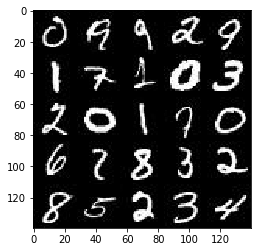

In [16]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

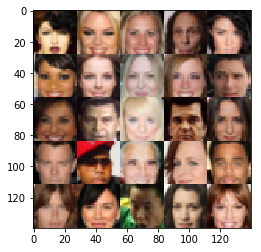

In [17]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [18]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [19]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='real_input')
    z    = tf.placeholder(tf.float32, (None, z_dim), name='z_data')
    lr   = tf.placeholder(tf.float32, None, name='learn_rate')

    return (real, z, lr)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [20]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        layer_1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu_1  = tf.maximum(alpha * layer_1, layer_1)
        
        layer_2 = tf.layers.conv2d(relu_1, 128, 5, strides=2, padding='same')
        batch_2 = tf.layers.batch_normalization(layer_2, training=True)
        relu_2  = tf.maximum(alpha * batch_2, batch_2)

        layer_3 = tf.layers.conv2d(relu_2, 256, 5, strides=2, padding='same')
        batch_3 = tf.layers.batch_normalization(layer_3, training=True)
        relu_3  = tf.maximum(alpha * batch_3, batch_3)
        
        compact = tf.reshape(relu_3, (-1, 4 * 4 * 256))
        logits  = tf.layers.dense(compact, 1)
        output  = tf.sigmoid(logits)
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [21]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
   
    with tf.variable_scope('generator', reuse=not is_train):
        layer_1 = tf.layers.dense(z, 7 * 7 * 512)
        layer_1 = tf.reshape(layer_1, (-1, 7, 7, 512))
        layer_1 = tf.layers.batch_normalization(layer_1, training=is_train)
        layer_1 = tf.maximum(alpha * layer_1, layer_1)
        
        layer_2 = tf.layers.conv2d_transpose(layer_1, 256, 5, strides=2, padding='same')
        layer_2 = tf.layers.batch_normalization(layer_2, training=is_train)
        layer_2 = tf.maximum(alpha * layer_2, layer_2)
    
        layer_3 = tf.layers.conv2d_transpose(layer_2, 128, 5, strides=1, padding='same')
        layer_3 = tf.layers.batch_normalization(layer_3, training=is_train)
        layer_3 = tf.maximum(alpha * layer_3, layer_3)
        
        logits  = tf.layers.conv2d_transpose(layer_3, out_channel_dim, 5, strides=2, padding='same') 
        
        output  = tf.tanh(logits)
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [22]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    generator_model = generator(z=input_z, out_channel_dim=out_channel_dim)
    
    real_discriminator, real_logits = discriminator(images=input_real, reuse=False)
    fake_discriminator, fake_logits = discriminator(images=generator_model, reuse=True)
    
    real_discriminator_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=real_logits, 
                                                labels=tf.ones_like(real_discriminator)))
    
    fake_discriminator_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_logits, 
                                                labels=tf.zeros_like(fake_discriminator)))
    
    generator_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_logits, 
                                                labels=tf.ones_like(fake_discriminator)))
    
    discriminator_loss = real_discriminator_loss + fake_discriminator_loss
    
    return discriminator_loss, generator_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [23]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    trainable_vars     = tf.trainable_variables()
    discriminator_vars = [var for var in trainable_vars if var.name.startswith('discriminator')]
    generator_vars     = [var for var in trainable_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        discriminator_training_optimizer = tf.train.AdamOptimizer(
            learning_rate, beta1=beta1).minimize(d_loss, var_list=discriminator_vars)
        
        generator_training_optimizer = tf.train.AdamOptimizer(
            learning_rate, beta1=beta1).minimize(g_loss, var_list=generator_vars)
        
    return discriminator_training_optimizer, generator_training_optimizer


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [24]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [25]:
class GAN(object):
    """
    Abstraction around:
    model_inputs
    model_loss
    model_opt
    """
    def __init__(self, data_shape, z_dim, learning_rate, beta1=0.5):
        height = data_shape[1]
        width = data_shape[2]
        channels = data_shape[3]
        print('height: {}, width: {}, channels: {}, z_dim: {}'.format(
                height, width, channels, z_dim))
        
        self.input_real, self.input_z, self.learning_rate = model_inputs(
            width, height, channels, z_dim)
        self.discriminator_loss, self.generator_loss = model_loss(
            self.input_real, self.input_z, channels)
        self.discriminator_opt, self.generator_opt = model_opt(
            self.discriminator_loss, self.generator_loss, self.learning_rate, beta1)
        
def build_feed_dict(network, batch_images, rand_z, learning_rate):
    feed_dict = {
        network.input_real: batch_images, 
        network.input_z: rand_z, 
        network.learning_rate: learning_rate
    }
    return feed_dict

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    network = GAN(data_shape, z_dim, learning_rate, beta1)
    
    saver = tf.train.Saver()
    
    samples, losses = [], []
    steps = 0
    
    print_progress = 25
    print_image    = 100
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images *= 2
                steps += 1
            
                rand_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                sess.run(network.discriminator_opt, 
                     feed_dict=build_feed_dict(network, batch_images, rand_z, learning_rate))
                
                sess.run(network.generator_opt,
                     feed_dict=build_feed_dict(network, batch_images, rand_z, learning_rate))
                
                sess.run(network.generator_opt,
                     feed_dict=build_feed_dict(network, batch_images, rand_z, learning_rate))
                
                if steps % print_progress == 0:
                    discriminator_train_loss = network.discriminator_loss.eval(
                        build_feed_dict(network, batch_images, rand_z, learning_rate))
    
                    generator_train_loss = network.generator_loss.eval(
                        build_feed_dict(network, batch_images, rand_z, learning_rate))
        
                    print("Epoch {}/{}...".format(epoch+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(discriminator_train_loss),
                          "Generator Loss: {:.4f}".format(generator_train_loss))
            
                    losses.append((discriminator_train_loss, generator_train_loss))

                if steps % print_image == 0:
                    show_generator_output(sess, 10, network.input_z, data_shape[3], data_image_mode)

        saver.save(sess, './checkpoints/generator.ckpt')
        
    return losses, samples

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

height: 28, width: 28, channels: 1, z_dim: 100
Epoch 1/2... Discriminator Loss: 2.5054... Generator Loss: 0.3928
Epoch 1/2... Discriminator Loss: 1.2978... Generator Loss: 0.5942
Epoch 1/2... Discriminator Loss: 1.6886... Generator Loss: 0.3602
Epoch 1/2... Discriminator Loss: 1.5898... Generator Loss: 0.7284


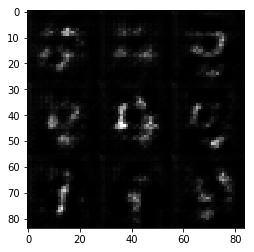

Epoch 1/2... Discriminator Loss: 1.6342... Generator Loss: 1.0899
Epoch 1/2... Discriminator Loss: 1.6576... Generator Loss: 0.3960
Epoch 1/2... Discriminator Loss: 1.6408... Generator Loss: 0.8028
Epoch 1/2... Discriminator Loss: 1.4369... Generator Loss: 0.5731


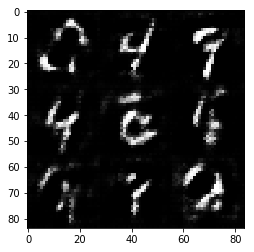

Epoch 1/2... Discriminator Loss: 1.5711... Generator Loss: 0.9489
Epoch 1/2... Discriminator Loss: 1.4811... Generator Loss: 0.9527
Epoch 1/2... Discriminator Loss: 1.4738... Generator Loss: 0.7194
Epoch 1/2... Discriminator Loss: 1.5438... Generator Loss: 1.0961


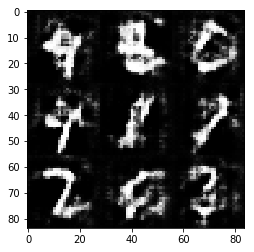

Epoch 1/2... Discriminator Loss: 1.4553... Generator Loss: 0.6039
Epoch 1/2... Discriminator Loss: 1.3909... Generator Loss: 0.5243
Epoch 1/2... Discriminator Loss: 1.4118... Generator Loss: 0.6049
Epoch 1/2... Discriminator Loss: 1.4786... Generator Loss: 0.9276


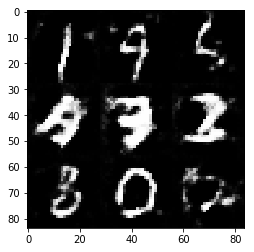

Epoch 1/2... Discriminator Loss: 1.5165... Generator Loss: 0.9801
Epoch 1/2... Discriminator Loss: 1.5482... Generator Loss: 0.9799
Epoch 2/2... Discriminator Loss: 1.4891... Generator Loss: 0.7587
Epoch 2/2... Discriminator Loss: 1.5181... Generator Loss: 0.4250


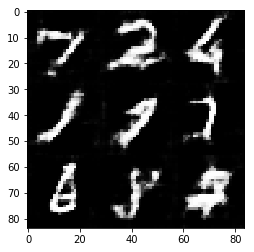

Epoch 2/2... Discriminator Loss: 1.3406... Generator Loss: 0.6638
Epoch 2/2... Discriminator Loss: 1.4263... Generator Loss: 0.5554
Epoch 2/2... Discriminator Loss: 1.5353... Generator Loss: 1.1102
Epoch 2/2... Discriminator Loss: 1.4103... Generator Loss: 0.8111


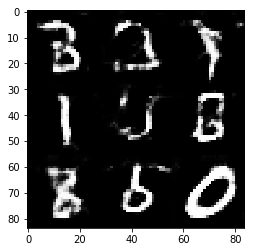

Epoch 2/2... Discriminator Loss: 1.3690... Generator Loss: 0.6052
Epoch 2/2... Discriminator Loss: 1.5201... Generator Loss: 0.3762
Epoch 2/2... Discriminator Loss: 1.4658... Generator Loss: 0.5023
Epoch 2/2... Discriminator Loss: 1.3823... Generator Loss: 0.6535


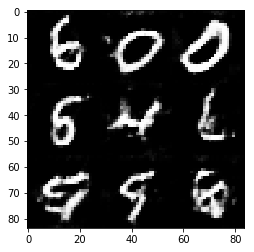

Epoch 2/2... Discriminator Loss: 1.4728... Generator Loss: 0.4560
Epoch 2/2... Discriminator Loss: 1.5132... Generator Loss: 0.4833
Epoch 2/2... Discriminator Loss: 1.4932... Generator Loss: 0.5374
Epoch 2/2... Discriminator Loss: 1.3979... Generator Loss: 0.5583


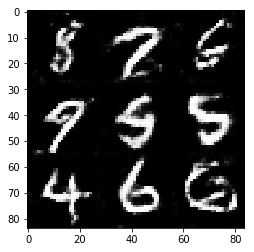

Epoch 2/2... Discriminator Loss: 1.4329... Generator Loss: 0.8007
Epoch 2/2... Discriminator Loss: 1.5083... Generator Loss: 0.3827
Epoch 2/2... Discriminator Loss: 1.4738... Generator Loss: 0.5300
Epoch 2/2... Discriminator Loss: 1.4425... Generator Loss: 0.5221


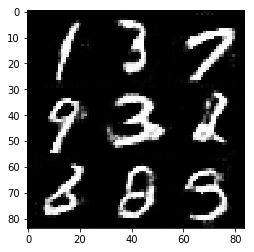

Epoch 2/2... Discriminator Loss: 1.4090... Generator Loss: 0.6000


In [26]:
batch_size    = 128
z_dim         = 100
learning_rate = 0.001
beta1         = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

height: 28, width: 28, channels: 3, z_dim: 200
Epoch 1/5... Discriminator Loss: 1.7543... Generator Loss: 0.6136
Epoch 1/5... Discriminator Loss: 2.8131... Generator Loss: 0.1051
Epoch 1/5... Discriminator Loss: 2.3105... Generator Loss: 0.1984
Epoch 1/5... Discriminator Loss: 2.3572... Generator Loss: 0.3418


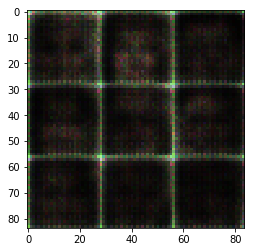

Epoch 1/5... Discriminator Loss: 2.0111... Generator Loss: 0.2531
Epoch 1/5... Discriminator Loss: 1.8003... Generator Loss: 0.3359
Epoch 1/5... Discriminator Loss: 1.6848... Generator Loss: 0.5706
Epoch 1/5... Discriminator Loss: 1.9162... Generator Loss: 0.3827


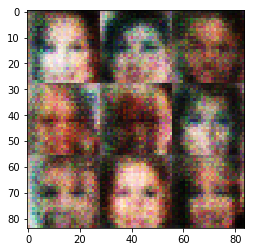

Epoch 1/5... Discriminator Loss: 1.9321... Generator Loss: 0.6711
Epoch 1/5... Discriminator Loss: 1.7608... Generator Loss: 0.3639
Epoch 1/5... Discriminator Loss: 1.7607... Generator Loss: 0.3596
Epoch 1/5... Discriminator Loss: 1.7353... Generator Loss: 0.6082


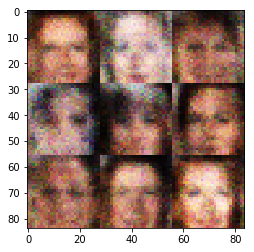

Epoch 1/5... Discriminator Loss: 1.7724... Generator Loss: 0.3068
Epoch 1/5... Discriminator Loss: 1.7204... Generator Loss: 0.4426
Epoch 1/5... Discriminator Loss: 1.6982... Generator Loss: 0.5023
Epoch 1/5... Discriminator Loss: 1.6599... Generator Loss: 0.4795


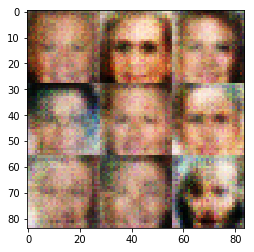

Epoch 1/5... Discriminator Loss: 1.6160... Generator Loss: 0.5305
Epoch 1/5... Discriminator Loss: 1.6041... Generator Loss: 0.4620
Epoch 1/5... Discriminator Loss: 1.5506... Generator Loss: 0.5560
Epoch 1/5... Discriminator Loss: 1.5971... Generator Loss: 0.4765


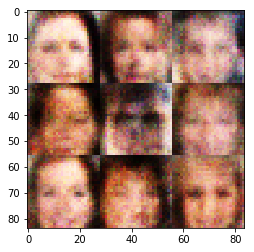

Epoch 1/5... Discriminator Loss: 1.6826... Generator Loss: 0.4125
Epoch 1/5... Discriminator Loss: 1.5141... Generator Loss: 0.5730
Epoch 1/5... Discriminator Loss: 1.5932... Generator Loss: 0.6530
Epoch 1/5... Discriminator Loss: 1.5838... Generator Loss: 0.5522


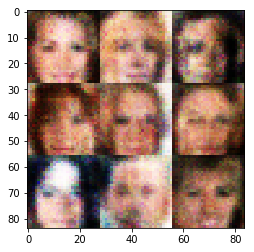

Epoch 1/5... Discriminator Loss: 1.5764... Generator Loss: 0.5985
Epoch 1/5... Discriminator Loss: 1.5314... Generator Loss: 0.5827
Epoch 1/5... Discriminator Loss: 1.5068... Generator Loss: 0.5602
Epoch 1/5... Discriminator Loss: 1.5875... Generator Loss: 0.6741


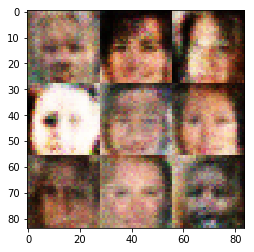

Epoch 1/5... Discriminator Loss: 1.4972... Generator Loss: 0.7232
Epoch 1/5... Discriminator Loss: 1.5025... Generator Loss: 0.6237
Epoch 1/5... Discriminator Loss: 1.5147... Generator Loss: 0.5513
Epoch 1/5... Discriminator Loss: 1.5494... Generator Loss: 0.5431


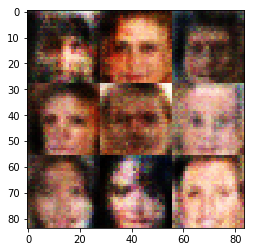

Epoch 1/5... Discriminator Loss: 1.5091... Generator Loss: 0.5589
Epoch 1/5... Discriminator Loss: 1.5491... Generator Loss: 0.5619
Epoch 1/5... Discriminator Loss: 1.5334... Generator Loss: 0.5335
Epoch 1/5... Discriminator Loss: 1.5516... Generator Loss: 0.6541


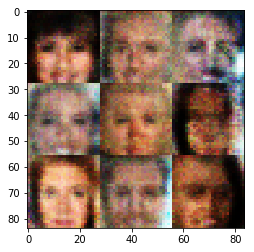

Epoch 1/5... Discriminator Loss: 1.5246... Generator Loss: 0.5492
Epoch 1/5... Discriminator Loss: 1.5131... Generator Loss: 0.6412
Epoch 1/5... Discriminator Loss: 1.5410... Generator Loss: 0.5445
Epoch 1/5... Discriminator Loss: 1.5155... Generator Loss: 0.5068


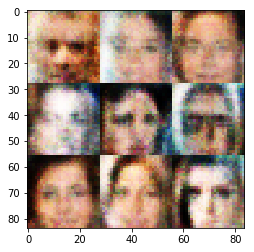

Epoch 1/5... Discriminator Loss: 1.5014... Generator Loss: 0.6026
Epoch 1/5... Discriminator Loss: 1.4964... Generator Loss: 0.5372
Epoch 1/5... Discriminator Loss: 1.4779... Generator Loss: 0.6388
Epoch 1/5... Discriminator Loss: 1.4674... Generator Loss: 0.6454


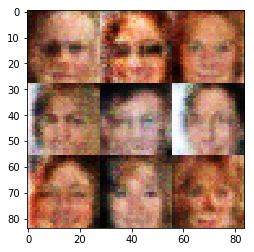

Epoch 1/5... Discriminator Loss: 1.5715... Generator Loss: 0.5680
Epoch 1/5... Discriminator Loss: 1.4968... Generator Loss: 0.6237
Epoch 1/5... Discriminator Loss: 1.4991... Generator Loss: 0.5973
Epoch 1/5... Discriminator Loss: 1.4752... Generator Loss: 0.6156


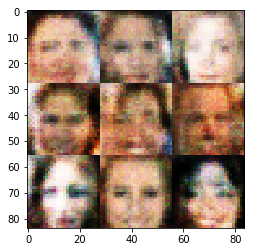

Epoch 1/5... Discriminator Loss: 1.4757... Generator Loss: 0.5897
Epoch 1/5... Discriminator Loss: 1.4917... Generator Loss: 0.5209
Epoch 1/5... Discriminator Loss: 1.5073... Generator Loss: 0.5535
Epoch 1/5... Discriminator Loss: 1.4911... Generator Loss: 0.6262


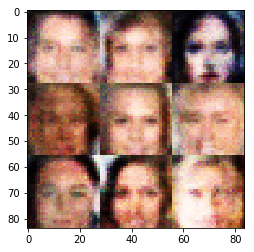

Epoch 1/5... Discriminator Loss: 1.4936... Generator Loss: 0.6149
Epoch 1/5... Discriminator Loss: 1.4762... Generator Loss: 0.5513
Epoch 1/5... Discriminator Loss: 1.4948... Generator Loss: 0.6499
Epoch 1/5... Discriminator Loss: 1.4726... Generator Loss: 0.6372


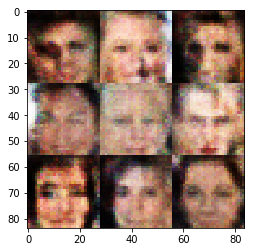

Epoch 1/5... Discriminator Loss: 1.5084... Generator Loss: 0.5327
Epoch 1/5... Discriminator Loss: 1.4822... Generator Loss: 0.5548
Epoch 1/5... Discriminator Loss: 1.4676... Generator Loss: 0.6536
Epoch 1/5... Discriminator Loss: 1.4720... Generator Loss: 0.5412


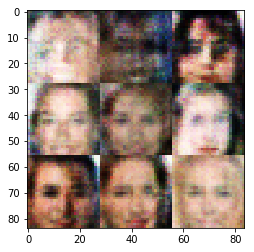

Epoch 1/5... Discriminator Loss: 1.4753... Generator Loss: 0.5896
Epoch 1/5... Discriminator Loss: 1.4980... Generator Loss: 0.5987
Epoch 1/5... Discriminator Loss: 1.4766... Generator Loss: 0.5936
Epoch 1/5... Discriminator Loss: 1.4624... Generator Loss: 0.6784


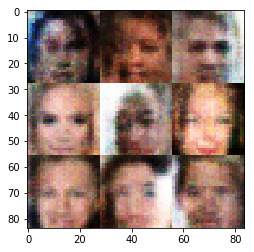

Epoch 1/5... Discriminator Loss: 1.4944... Generator Loss: 0.5531
Epoch 1/5... Discriminator Loss: 1.4908... Generator Loss: 0.6324
Epoch 1/5... Discriminator Loss: 1.4588... Generator Loss: 0.6628
Epoch 1/5... Discriminator Loss: 1.4746... Generator Loss: 0.5650


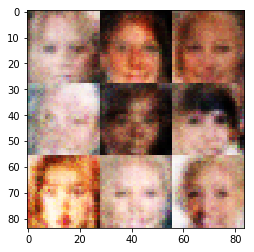

Epoch 1/5... Discriminator Loss: 1.4380... Generator Loss: 0.6519
Epoch 1/5... Discriminator Loss: 1.4724... Generator Loss: 0.6024
Epoch 1/5... Discriminator Loss: 1.4774... Generator Loss: 0.6005
Epoch 1/5... Discriminator Loss: 1.5091... Generator Loss: 0.5499


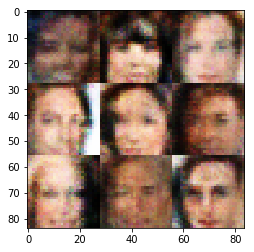

Epoch 1/5... Discriminator Loss: 1.4582... Generator Loss: 0.5861
Epoch 1/5... Discriminator Loss: 1.4756... Generator Loss: 0.6295
Epoch 1/5... Discriminator Loss: 1.4791... Generator Loss: 0.6043
Epoch 1/5... Discriminator Loss: 1.4755... Generator Loss: 0.6279


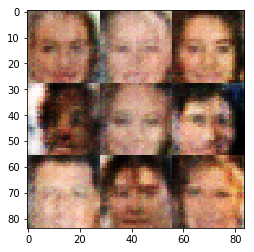

Epoch 1/5... Discriminator Loss: 1.4610... Generator Loss: 0.7133
Epoch 1/5... Discriminator Loss: 1.4797... Generator Loss: 0.6325
Epoch 1/5... Discriminator Loss: 1.4350... Generator Loss: 0.6310
Epoch 1/5... Discriminator Loss: 1.4478... Generator Loss: 0.6266


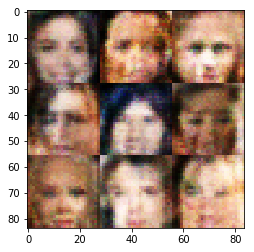

Epoch 1/5... Discriminator Loss: 1.4970... Generator Loss: 0.7136
Epoch 1/5... Discriminator Loss: 1.4627... Generator Loss: 0.7015
Epoch 1/5... Discriminator Loss: 1.4208... Generator Loss: 0.6295
Epoch 1/5... Discriminator Loss: 1.4548... Generator Loss: 0.6315


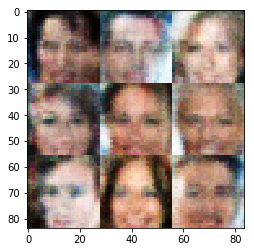

Epoch 1/5... Discriminator Loss: 1.4658... Generator Loss: 0.5993
Epoch 1/5... Discriminator Loss: 1.4565... Generator Loss: 0.6824
Epoch 1/5... Discriminator Loss: 1.4574... Generator Loss: 0.6559
Epoch 1/5... Discriminator Loss: 1.4967... Generator Loss: 0.6744


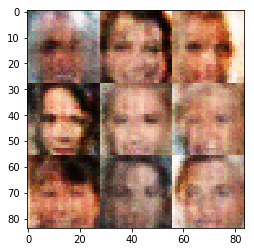

Epoch 1/5... Discriminator Loss: 1.4662... Generator Loss: 0.6676
Epoch 1/5... Discriminator Loss: 1.4698... Generator Loss: 0.6044
Epoch 1/5... Discriminator Loss: 1.4534... Generator Loss: 0.6768
Epoch 1/5... Discriminator Loss: 1.4341... Generator Loss: 0.7052


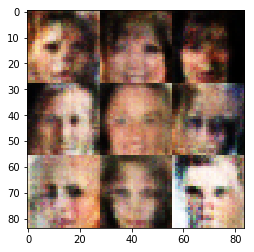

Epoch 1/5... Discriminator Loss: 1.4512... Generator Loss: 0.5953
Epoch 1/5... Discriminator Loss: 1.4537... Generator Loss: 0.6241
Epoch 1/5... Discriminator Loss: 1.4673... Generator Loss: 0.6033
Epoch 1/5... Discriminator Loss: 1.4567... Generator Loss: 0.6226


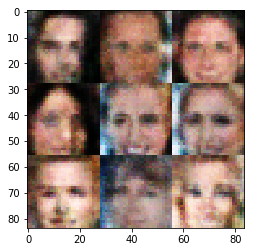

Epoch 1/5... Discriminator Loss: 1.4556... Generator Loss: 0.5910
Epoch 1/5... Discriminator Loss: 1.4753... Generator Loss: 0.5690
Epoch 1/5... Discriminator Loss: 1.4623... Generator Loss: 0.5938
Epoch 1/5... Discriminator Loss: 1.4459... Generator Loss: 0.6832


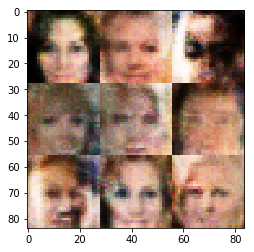

Epoch 1/5... Discriminator Loss: 1.4615... Generator Loss: 0.6609
Epoch 1/5... Discriminator Loss: 1.4536... Generator Loss: 0.6714
Epoch 1/5... Discriminator Loss: 1.4893... Generator Loss: 0.6427
Epoch 1/5... Discriminator Loss: 1.4314... Generator Loss: 0.6481


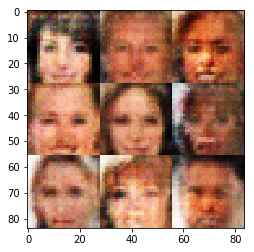

Epoch 1/5... Discriminator Loss: 1.4430... Generator Loss: 0.6046
Epoch 1/5... Discriminator Loss: 1.4608... Generator Loss: 0.5651
Epoch 1/5... Discriminator Loss: 1.4193... Generator Loss: 0.6385
Epoch 1/5... Discriminator Loss: 1.4371... Generator Loss: 0.6208


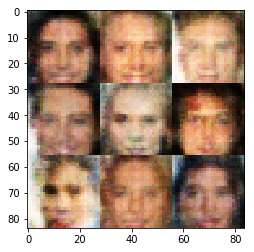

Epoch 1/5... Discriminator Loss: 1.4771... Generator Loss: 0.6462
Epoch 1/5... Discriminator Loss: 1.4711... Generator Loss: 0.6647
Epoch 1/5... Discriminator Loss: 1.4466... Generator Loss: 0.6468
Epoch 1/5... Discriminator Loss: 1.4435... Generator Loss: 0.5728


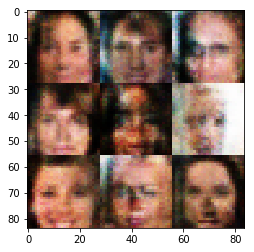

Epoch 1/5... Discriminator Loss: 1.4686... Generator Loss: 0.5987
Epoch 1/5... Discriminator Loss: 1.4625... Generator Loss: 0.6115
Epoch 1/5... Discriminator Loss: 1.4370... Generator Loss: 0.6307
Epoch 1/5... Discriminator Loss: 1.4634... Generator Loss: 0.6801


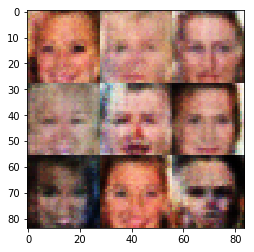

Epoch 1/5... Discriminator Loss: 1.4449... Generator Loss: 0.5878
Epoch 1/5... Discriminator Loss: 1.4516... Generator Loss: 0.6848
Epoch 1/5... Discriminator Loss: 1.4600... Generator Loss: 0.6300
Epoch 1/5... Discriminator Loss: 1.4412... Generator Loss: 0.6279


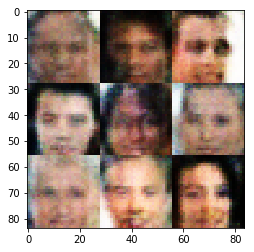

Epoch 1/5... Discriminator Loss: 1.4878... Generator Loss: 0.5207
Epoch 1/5... Discriminator Loss: 1.4543... Generator Loss: 0.6987
Epoch 1/5... Discriminator Loss: 1.4755... Generator Loss: 0.5965
Epoch 1/5... Discriminator Loss: 1.4364... Generator Loss: 0.6363


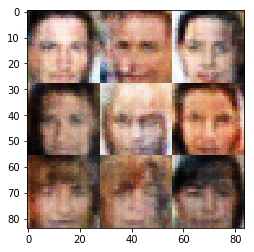

Epoch 1/5... Discriminator Loss: 1.4279... Generator Loss: 0.6214
Epoch 1/5... Discriminator Loss: 1.4685... Generator Loss: 0.5818
Epoch 2/5... Discriminator Loss: 1.4529... Generator Loss: 0.5905
Epoch 2/5... Discriminator Loss: 1.4446... Generator Loss: 0.6086


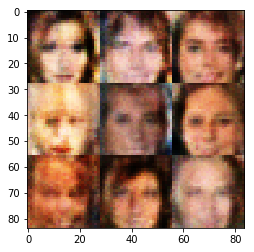

Epoch 2/5... Discriminator Loss: 1.4897... Generator Loss: 0.5314
Epoch 2/5... Discriminator Loss: 1.4740... Generator Loss: 0.5607
Epoch 2/5... Discriminator Loss: 1.4419... Generator Loss: 0.6748
Epoch 2/5... Discriminator Loss: 1.4473... Generator Loss: 0.6817


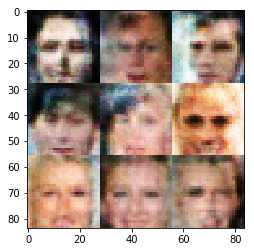

Epoch 2/5... Discriminator Loss: 1.4621... Generator Loss: 0.6147
Epoch 2/5... Discriminator Loss: 1.4393... Generator Loss: 0.6827
Epoch 2/5... Discriminator Loss: 1.4663... Generator Loss: 0.6996
Epoch 2/5... Discriminator Loss: 1.4468... Generator Loss: 0.5707


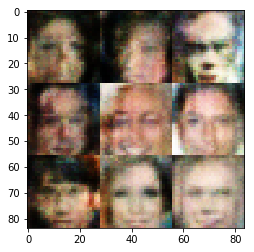

Epoch 2/5... Discriminator Loss: 1.4514... Generator Loss: 0.6235
Epoch 2/5... Discriminator Loss: 1.4560... Generator Loss: 0.6323
Epoch 2/5... Discriminator Loss: 1.4438... Generator Loss: 0.7442
Epoch 2/5... Discriminator Loss: 1.4391... Generator Loss: 0.5717


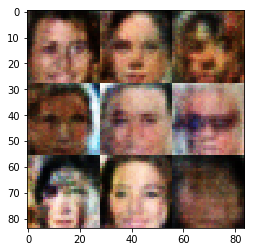

Epoch 2/5... Discriminator Loss: 1.4638... Generator Loss: 0.6370
Epoch 2/5... Discriminator Loss: 1.4440... Generator Loss: 0.5748
Epoch 2/5... Discriminator Loss: 1.4464... Generator Loss: 0.6548
Epoch 2/5... Discriminator Loss: 1.4419... Generator Loss: 0.6738


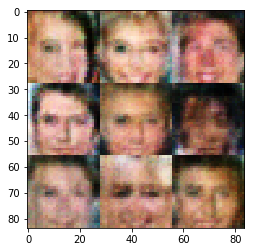

Epoch 2/5... Discriminator Loss: 1.4512... Generator Loss: 0.7445
Epoch 2/5... Discriminator Loss: 1.4450... Generator Loss: 0.6966
Epoch 2/5... Discriminator Loss: 1.4341... Generator Loss: 0.6559
Epoch 2/5... Discriminator Loss: 1.4215... Generator Loss: 0.6893


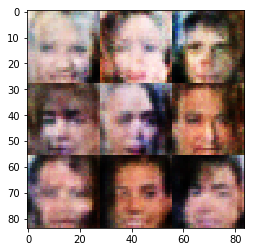

Epoch 2/5... Discriminator Loss: 1.4527... Generator Loss: 0.6255
Epoch 2/5... Discriminator Loss: 1.4573... Generator Loss: 0.5608
Epoch 2/5... Discriminator Loss: 1.4704... Generator Loss: 0.6312
Epoch 2/5... Discriminator Loss: 1.4632... Generator Loss: 0.6416


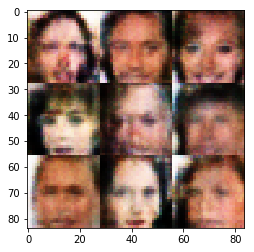

Epoch 2/5... Discriminator Loss: 1.4690... Generator Loss: 0.6036
Epoch 2/5... Discriminator Loss: 1.4356... Generator Loss: 0.6360
Epoch 2/5... Discriminator Loss: 1.4257... Generator Loss: 0.6202
Epoch 2/5... Discriminator Loss: 1.4337... Generator Loss: 0.7369


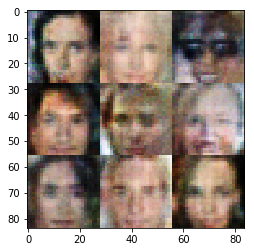

Epoch 2/5... Discriminator Loss: 1.4322... Generator Loss: 0.6611
Epoch 2/5... Discriminator Loss: 1.4456... Generator Loss: 0.6146
Epoch 2/5... Discriminator Loss: 1.4417... Generator Loss: 0.5707
Epoch 2/5... Discriminator Loss: 1.4577... Generator Loss: 0.6076


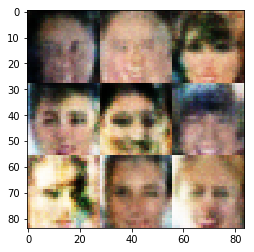

Epoch 2/5... Discriminator Loss: 1.4394... Generator Loss: 0.6213
Epoch 2/5... Discriminator Loss: 1.4298... Generator Loss: 0.6404
Epoch 2/5... Discriminator Loss: 1.4291... Generator Loss: 0.7051
Epoch 2/5... Discriminator Loss: 1.4417... Generator Loss: 0.5780


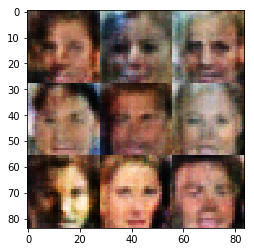

Epoch 2/5... Discriminator Loss: 1.4595... Generator Loss: 0.7570
Epoch 2/5... Discriminator Loss: 1.4195... Generator Loss: 0.6963
Epoch 2/5... Discriminator Loss: 1.4309... Generator Loss: 0.6524
Epoch 2/5... Discriminator Loss: 1.4605... Generator Loss: 0.6137


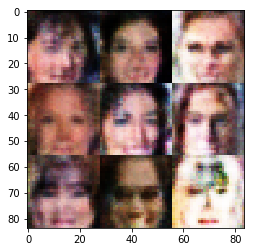

Epoch 2/5... Discriminator Loss: 1.4288... Generator Loss: 0.6591
Epoch 2/5... Discriminator Loss: 1.4305... Generator Loss: 0.6402
Epoch 2/5... Discriminator Loss: 1.4369... Generator Loss: 0.5908
Epoch 2/5... Discriminator Loss: 1.4457... Generator Loss: 0.5807


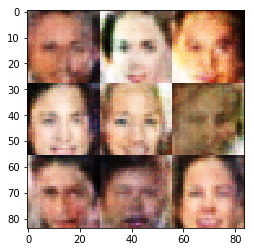

Epoch 2/5... Discriminator Loss: 1.4123... Generator Loss: 0.6904
Epoch 2/5... Discriminator Loss: 1.4407... Generator Loss: 0.6035
Epoch 2/5... Discriminator Loss: 1.4417... Generator Loss: 0.5656
Epoch 2/5... Discriminator Loss: 1.4166... Generator Loss: 0.6262


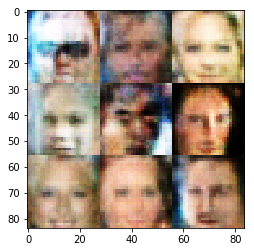

Epoch 2/5... Discriminator Loss: 1.4296... Generator Loss: 0.7026
Epoch 2/5... Discriminator Loss: 1.4210... Generator Loss: 0.6103
Epoch 2/5... Discriminator Loss: 1.4308... Generator Loss: 0.6850
Epoch 2/5... Discriminator Loss: 1.4460... Generator Loss: 0.6266


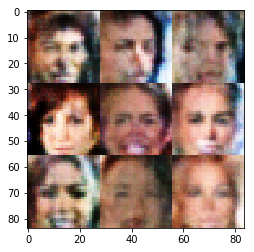

Epoch 2/5... Discriminator Loss: 1.4500... Generator Loss: 0.6194
Epoch 2/5... Discriminator Loss: 1.4318... Generator Loss: 0.6379
Epoch 2/5... Discriminator Loss: 1.4358... Generator Loss: 0.6533
Epoch 2/5... Discriminator Loss: 1.4659... Generator Loss: 0.5573


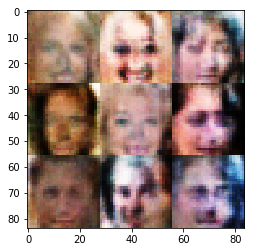

Epoch 2/5... Discriminator Loss: 1.4063... Generator Loss: 0.6931
Epoch 2/5... Discriminator Loss: 1.4751... Generator Loss: 0.7100
Epoch 2/5... Discriminator Loss: 1.4337... Generator Loss: 0.6825
Epoch 2/5... Discriminator Loss: 1.4426... Generator Loss: 0.6456


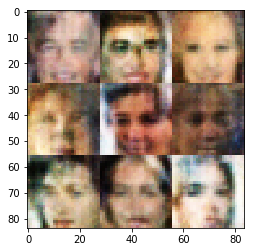

Epoch 2/5... Discriminator Loss: 1.4270... Generator Loss: 0.6572
Epoch 2/5... Discriminator Loss: 1.4585... Generator Loss: 0.7305
Epoch 2/5... Discriminator Loss: 1.4129... Generator Loss: 0.6994
Epoch 2/5... Discriminator Loss: 1.4187... Generator Loss: 0.6558


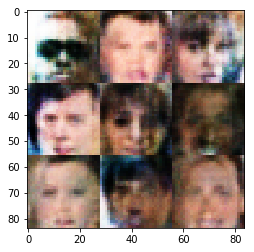

Epoch 2/5... Discriminator Loss: 1.4192... Generator Loss: 0.6441
Epoch 2/5... Discriminator Loss: 1.4202... Generator Loss: 0.6494
Epoch 2/5... Discriminator Loss: 1.4400... Generator Loss: 0.6425
Epoch 2/5... Discriminator Loss: 1.4196... Generator Loss: 0.7206


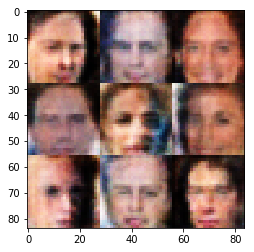

Epoch 2/5... Discriminator Loss: 1.4198... Generator Loss: 0.6697
Epoch 2/5... Discriminator Loss: 1.4411... Generator Loss: 0.6259
Epoch 2/5... Discriminator Loss: 1.4466... Generator Loss: 0.6460
Epoch 2/5... Discriminator Loss: 1.4340... Generator Loss: 0.6293


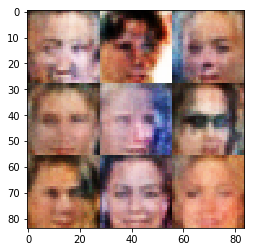

Epoch 2/5... Discriminator Loss: 1.4193... Generator Loss: 0.6186
Epoch 2/5... Discriminator Loss: 1.4282... Generator Loss: 0.6196
Epoch 2/5... Discriminator Loss: 1.4243... Generator Loss: 0.6836
Epoch 2/5... Discriminator Loss: 1.4060... Generator Loss: 0.6657


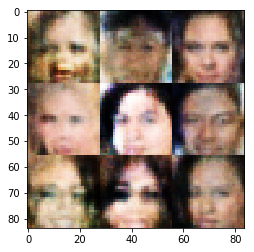

Epoch 2/5... Discriminator Loss: 1.4076... Generator Loss: 0.6450
Epoch 2/5... Discriminator Loss: 1.4188... Generator Loss: 0.6881
Epoch 2/5... Discriminator Loss: 1.4430... Generator Loss: 0.5692
Epoch 2/5... Discriminator Loss: 1.4298... Generator Loss: 0.6345


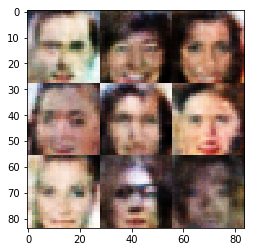

Epoch 2/5... Discriminator Loss: 1.4466... Generator Loss: 0.7067
Epoch 2/5... Discriminator Loss: 1.4369... Generator Loss: 0.6821
Epoch 2/5... Discriminator Loss: 1.4222... Generator Loss: 0.7268
Epoch 2/5... Discriminator Loss: 1.4453... Generator Loss: 0.6317


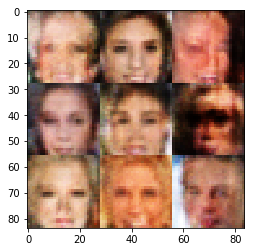

Epoch 2/5... Discriminator Loss: 1.4212... Generator Loss: 0.6364
Epoch 2/5... Discriminator Loss: 1.4584... Generator Loss: 0.6779
Epoch 2/5... Discriminator Loss: 1.4547... Generator Loss: 0.5951
Epoch 2/5... Discriminator Loss: 1.4205... Generator Loss: 0.5961


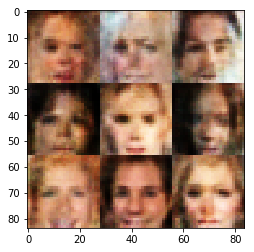

Epoch 2/5... Discriminator Loss: 1.4532... Generator Loss: 0.6194
Epoch 2/5... Discriminator Loss: 1.4268... Generator Loss: 0.6687
Epoch 2/5... Discriminator Loss: 1.4327... Generator Loss: 0.5981
Epoch 2/5... Discriminator Loss: 1.4207... Generator Loss: 0.6496


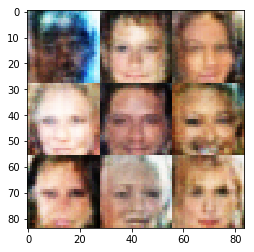

Epoch 2/5... Discriminator Loss: 1.4308... Generator Loss: 0.6266
Epoch 2/5... Discriminator Loss: 1.4604... Generator Loss: 0.5400
Epoch 2/5... Discriminator Loss: 1.4371... Generator Loss: 0.5625
Epoch 2/5... Discriminator Loss: 1.4105... Generator Loss: 0.6035


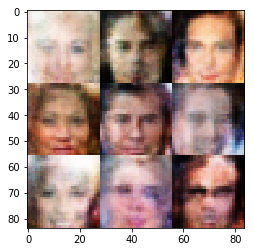

Epoch 2/5... Discriminator Loss: 1.4190... Generator Loss: 0.6160
Epoch 2/5... Discriminator Loss: 1.4209... Generator Loss: 0.6530
Epoch 2/5... Discriminator Loss: 1.4268... Generator Loss: 0.7138
Epoch 2/5... Discriminator Loss: 1.4209... Generator Loss: 0.6508


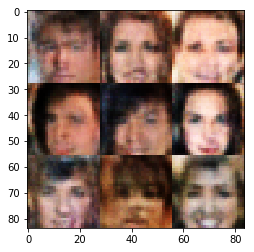

Epoch 2/5... Discriminator Loss: 1.4335... Generator Loss: 0.6230
Epoch 2/5... Discriminator Loss: 1.4420... Generator Loss: 0.7115
Epoch 2/5... Discriminator Loss: 1.4280... Generator Loss: 0.6501
Epoch 2/5... Discriminator Loss: 1.4388... Generator Loss: 0.6822


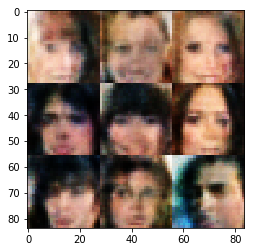

Epoch 2/5... Discriminator Loss: 1.4212... Generator Loss: 0.7037
Epoch 2/5... Discriminator Loss: 1.4152... Generator Loss: 0.6686
Epoch 2/5... Discriminator Loss: 1.4143... Generator Loss: 0.6757
Epoch 2/5... Discriminator Loss: 1.4159... Generator Loss: 0.6428


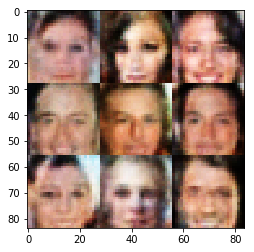

Epoch 2/5... Discriminator Loss: 1.4339... Generator Loss: 0.6220
Epoch 2/5... Discriminator Loss: 1.4225... Generator Loss: 0.6750
Epoch 2/5... Discriminator Loss: 1.4220... Generator Loss: 0.6131
Epoch 2/5... Discriminator Loss: 1.4100... Generator Loss: 0.6409


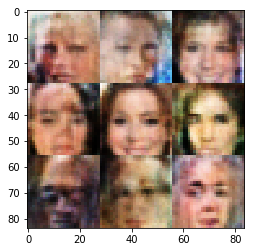

Epoch 2/5... Discriminator Loss: 1.4111... Generator Loss: 0.6801
Epoch 2/5... Discriminator Loss: 1.4356... Generator Loss: 0.5685
Epoch 2/5... Discriminator Loss: 1.4261... Generator Loss: 0.6366
Epoch 2/5... Discriminator Loss: 1.4460... Generator Loss: 0.6160


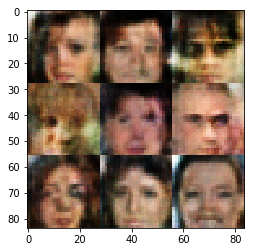

Epoch 2/5... Discriminator Loss: 1.4231... Generator Loss: 0.6838
Epoch 2/5... Discriminator Loss: 1.4418... Generator Loss: 0.6237
Epoch 2/5... Discriminator Loss: 1.4136... Generator Loss: 0.5995
Epoch 2/5... Discriminator Loss: 1.4110... Generator Loss: 0.7639


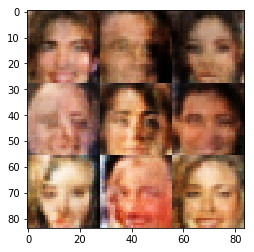

Epoch 2/5... Discriminator Loss: 1.4340... Generator Loss: 0.6636
Epoch 2/5... Discriminator Loss: 1.4134... Generator Loss: 0.6388
Epoch 2/5... Discriminator Loss: 1.4393... Generator Loss: 0.6216
Epoch 2/5... Discriminator Loss: 1.4124... Generator Loss: 0.6582


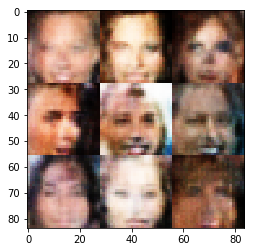

Epoch 2/5... Discriminator Loss: 1.4149... Generator Loss: 0.6303
Epoch 3/5... Discriminator Loss: 1.4273... Generator Loss: 0.6285
Epoch 3/5... Discriminator Loss: 1.4128... Generator Loss: 0.6651
Epoch 3/5... Discriminator Loss: 1.4076... Generator Loss: 0.6656


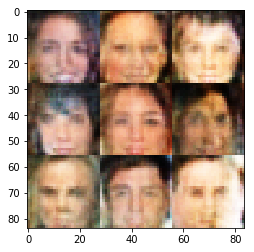

Epoch 3/5... Discriminator Loss: 1.4301... Generator Loss: 0.6178
Epoch 3/5... Discriminator Loss: 1.4344... Generator Loss: 0.6316
Epoch 3/5... Discriminator Loss: 1.4192... Generator Loss: 0.5821
Epoch 3/5... Discriminator Loss: 1.4226... Generator Loss: 0.6147


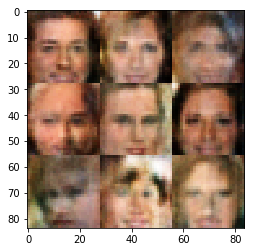

Epoch 3/5... Discriminator Loss: 1.4173... Generator Loss: 0.6834
Epoch 3/5... Discriminator Loss: 1.4196... Generator Loss: 0.6612
Epoch 3/5... Discriminator Loss: 1.4237... Generator Loss: 0.6487
Epoch 3/5... Discriminator Loss: 1.4320... Generator Loss: 0.6399


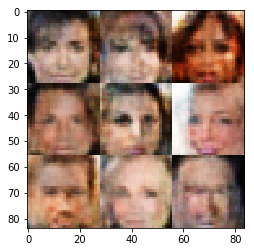

Epoch 3/5... Discriminator Loss: 1.4357... Generator Loss: 0.5969
Epoch 3/5... Discriminator Loss: 1.4335... Generator Loss: 0.6741
Epoch 3/5... Discriminator Loss: 1.4103... Generator Loss: 0.6960
Epoch 3/5... Discriminator Loss: 1.4263... Generator Loss: 0.6410


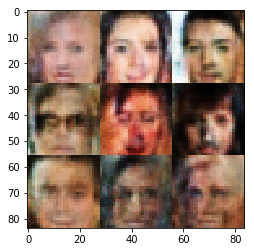

Epoch 3/5... Discriminator Loss: 1.4273... Generator Loss: 0.7182
Epoch 3/5... Discriminator Loss: 1.4141... Generator Loss: 0.6191
Epoch 3/5... Discriminator Loss: 1.4251... Generator Loss: 0.6780
Epoch 3/5... Discriminator Loss: 1.4201... Generator Loss: 0.6460


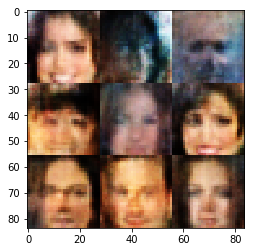

Epoch 3/5... Discriminator Loss: 1.4270... Generator Loss: 0.6381
Epoch 3/5... Discriminator Loss: 1.4224... Generator Loss: 0.6906
Epoch 3/5... Discriminator Loss: 1.4155... Generator Loss: 0.7109
Epoch 3/5... Discriminator Loss: 1.4346... Generator Loss: 0.7999


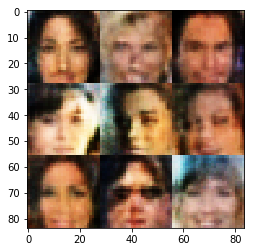

Epoch 3/5... Discriminator Loss: 1.3970... Generator Loss: 0.6800
Epoch 3/5... Discriminator Loss: 1.4367... Generator Loss: 0.5580
Epoch 3/5... Discriminator Loss: 1.3993... Generator Loss: 0.6843
Epoch 3/5... Discriminator Loss: 1.3997... Generator Loss: 0.6631


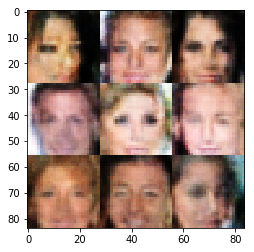

Epoch 3/5... Discriminator Loss: 1.4224... Generator Loss: 0.6242
Epoch 3/5... Discriminator Loss: 1.4536... Generator Loss: 0.5659
Epoch 3/5... Discriminator Loss: 1.4162... Generator Loss: 0.6717
Epoch 3/5... Discriminator Loss: 1.4181... Generator Loss: 0.6298


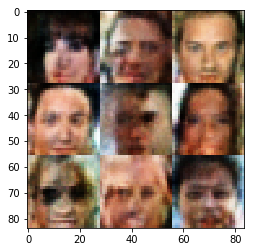

Epoch 3/5... Discriminator Loss: 1.4173... Generator Loss: 0.7232
Epoch 3/5... Discriminator Loss: 1.4079... Generator Loss: 0.6466
Epoch 3/5... Discriminator Loss: 1.4403... Generator Loss: 0.6950
Epoch 3/5... Discriminator Loss: 1.4210... Generator Loss: 0.6725


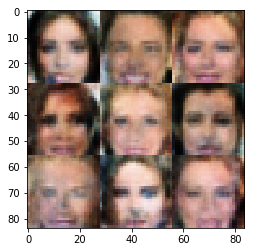

Epoch 3/5... Discriminator Loss: 1.4296... Generator Loss: 0.6120
Epoch 3/5... Discriminator Loss: 1.4364... Generator Loss: 0.5608
Epoch 3/5... Discriminator Loss: 1.4105... Generator Loss: 0.6579
Epoch 3/5... Discriminator Loss: 1.4115... Generator Loss: 0.6575


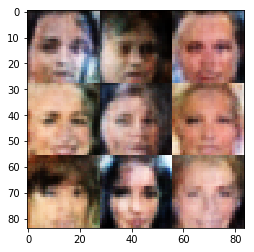

Epoch 3/5... Discriminator Loss: 1.4082... Generator Loss: 0.6873
Epoch 3/5... Discriminator Loss: 1.4113... Generator Loss: 0.6106
Epoch 3/5... Discriminator Loss: 1.4011... Generator Loss: 0.6189
Epoch 3/5... Discriminator Loss: 1.4100... Generator Loss: 0.6068


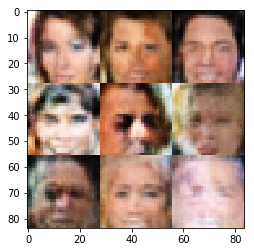

Epoch 3/5... Discriminator Loss: 1.4247... Generator Loss: 0.7088
Epoch 3/5... Discriminator Loss: 1.4048... Generator Loss: 0.6924
Epoch 3/5... Discriminator Loss: 1.4102... Generator Loss: 0.6418
Epoch 3/5... Discriminator Loss: 1.4368... Generator Loss: 0.6496


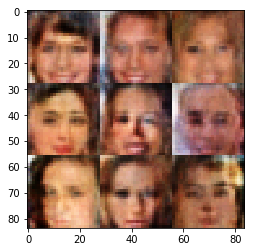

Epoch 3/5... Discriminator Loss: 1.4136... Generator Loss: 0.7022
Epoch 3/5... Discriminator Loss: 1.4185... Generator Loss: 0.6430
Epoch 3/5... Discriminator Loss: 1.4207... Generator Loss: 0.6485
Epoch 3/5... Discriminator Loss: 1.4214... Generator Loss: 0.6959


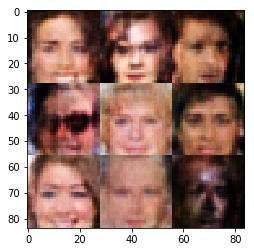

Epoch 3/5... Discriminator Loss: 1.4180... Generator Loss: 0.7076
Epoch 3/5... Discriminator Loss: 1.4131... Generator Loss: 0.6242
Epoch 3/5... Discriminator Loss: 1.4100... Generator Loss: 0.6662
Epoch 3/5... Discriminator Loss: 1.4178... Generator Loss: 0.6607


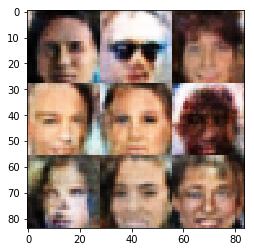

Epoch 3/5... Discriminator Loss: 1.4068... Generator Loss: 0.6430
Epoch 3/5... Discriminator Loss: 1.4182... Generator Loss: 0.6921
Epoch 3/5... Discriminator Loss: 1.4064... Generator Loss: 0.7005
Epoch 3/5... Discriminator Loss: 1.4144... Generator Loss: 0.7582


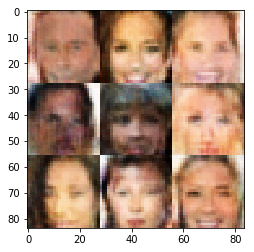

Epoch 3/5... Discriminator Loss: 1.4234... Generator Loss: 0.5959
Epoch 3/5... Discriminator Loss: 1.4168... Generator Loss: 0.6430
Epoch 3/5... Discriminator Loss: 1.4192... Generator Loss: 0.6483
Epoch 3/5... Discriminator Loss: 1.4141... Generator Loss: 0.6520


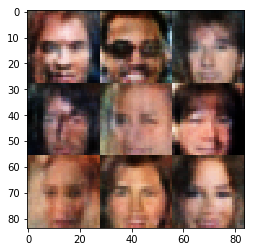

Epoch 3/5... Discriminator Loss: 1.4227... Generator Loss: 0.6500
Epoch 3/5... Discriminator Loss: 1.4083... Generator Loss: 0.6947
Epoch 3/5... Discriminator Loss: 1.4345... Generator Loss: 0.5218
Epoch 3/5... Discriminator Loss: 1.3947... Generator Loss: 0.7337


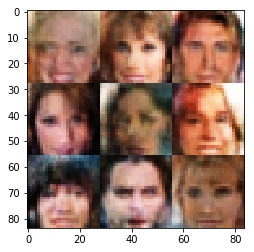

Epoch 3/5... Discriminator Loss: 1.4172... Generator Loss: 0.6377
Epoch 3/5... Discriminator Loss: 1.4126... Generator Loss: 0.6071
Epoch 3/5... Discriminator Loss: 1.4132... Generator Loss: 0.6358
Epoch 3/5... Discriminator Loss: 1.4127... Generator Loss: 0.6313


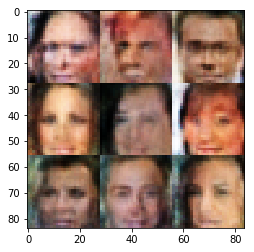

Epoch 3/5... Discriminator Loss: 1.4103... Generator Loss: 0.6548
Epoch 3/5... Discriminator Loss: 1.3950... Generator Loss: 0.6639
Epoch 3/5... Discriminator Loss: 1.4170... Generator Loss: 0.6124
Epoch 3/5... Discriminator Loss: 1.4275... Generator Loss: 0.6172


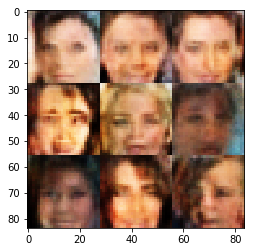

Epoch 3/5... Discriminator Loss: 1.4181... Generator Loss: 0.6112
Epoch 3/5... Discriminator Loss: 1.4092... Generator Loss: 0.6114
Epoch 3/5... Discriminator Loss: 1.4190... Generator Loss: 0.6143
Epoch 3/5... Discriminator Loss: 1.4059... Generator Loss: 0.6214


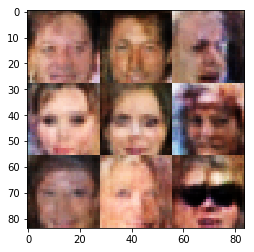

Epoch 3/5... Discriminator Loss: 1.4159... Generator Loss: 0.6259
Epoch 3/5... Discriminator Loss: 1.4121... Generator Loss: 0.6556
Epoch 3/5... Discriminator Loss: 1.4172... Generator Loss: 0.6129
Epoch 3/5... Discriminator Loss: 1.4223... Generator Loss: 0.6208


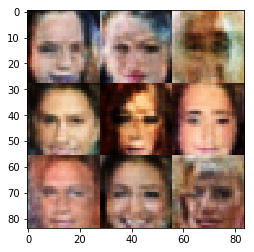

Epoch 3/5... Discriminator Loss: 1.4121... Generator Loss: 0.6677
Epoch 3/5... Discriminator Loss: 1.4197... Generator Loss: 0.6388
Epoch 3/5... Discriminator Loss: 1.4182... Generator Loss: 0.6381
Epoch 3/5... Discriminator Loss: 1.4166... Generator Loss: 0.6887


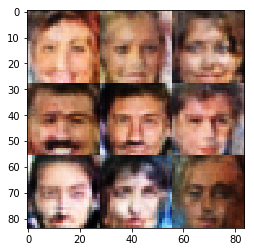

Epoch 3/5... Discriminator Loss: 1.4176... Generator Loss: 0.6608
Epoch 3/5... Discriminator Loss: 1.4014... Generator Loss: 0.6966
Epoch 3/5... Discriminator Loss: 1.4161... Generator Loss: 0.6348
Epoch 3/5... Discriminator Loss: 1.4072... Generator Loss: 0.6482


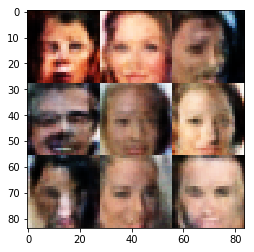

Epoch 3/5... Discriminator Loss: 1.4147... Generator Loss: 0.6444
Epoch 3/5... Discriminator Loss: 1.4180... Generator Loss: 0.6609
Epoch 3/5... Discriminator Loss: 1.4189... Generator Loss: 0.6839
Epoch 3/5... Discriminator Loss: 1.4291... Generator Loss: 0.6594


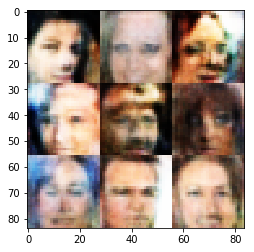

Epoch 3/5... Discriminator Loss: 1.4291... Generator Loss: 0.6812
Epoch 3/5... Discriminator Loss: 1.4231... Generator Loss: 0.7401
Epoch 3/5... Discriminator Loss: 1.4157... Generator Loss: 0.6654
Epoch 3/5... Discriminator Loss: 1.4045... Generator Loss: 0.6653


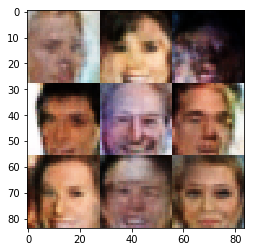

Epoch 3/5... Discriminator Loss: 1.4178... Generator Loss: 0.7066
Epoch 3/5... Discriminator Loss: 1.4195... Generator Loss: 0.6237
Epoch 3/5... Discriminator Loss: 1.4218... Generator Loss: 0.6000
Epoch 3/5... Discriminator Loss: 1.4276... Generator Loss: 0.6314


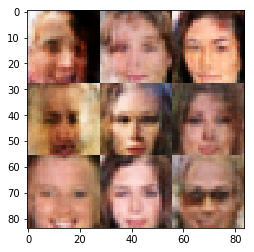

Epoch 3/5... Discriminator Loss: 1.4085... Generator Loss: 0.7043
Epoch 3/5... Discriminator Loss: 1.4105... Generator Loss: 0.6230
Epoch 3/5... Discriminator Loss: 1.4233... Generator Loss: 0.6313
Epoch 3/5... Discriminator Loss: 1.4013... Generator Loss: 0.6768


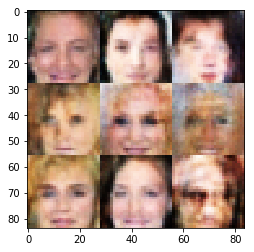

Epoch 3/5... Discriminator Loss: 1.4444... Generator Loss: 0.6219
Epoch 3/5... Discriminator Loss: 1.4201... Generator Loss: 0.6214
Epoch 3/5... Discriminator Loss: 1.4117... Generator Loss: 0.7289
Epoch 3/5... Discriminator Loss: 1.4026... Generator Loss: 0.6674


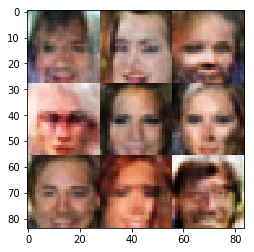

Epoch 3/5... Discriminator Loss: 1.4113... Generator Loss: 0.6933
Epoch 3/5... Discriminator Loss: 1.4193... Generator Loss: 0.6597
Epoch 3/5... Discriminator Loss: 1.4075... Generator Loss: 0.7161
Epoch 3/5... Discriminator Loss: 1.4220... Generator Loss: 0.6476


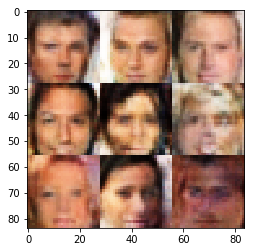

Epoch 3/5... Discriminator Loss: 1.4092... Generator Loss: 0.6368
Epoch 3/5... Discriminator Loss: 1.4117... Generator Loss: 0.6579
Epoch 3/5... Discriminator Loss: 1.4064... Generator Loss: 0.6393
Epoch 3/5... Discriminator Loss: 1.4126... Generator Loss: 0.6052


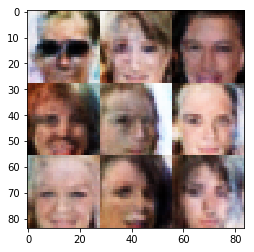

Epoch 3/5... Discriminator Loss: 1.4098... Generator Loss: 0.6658
Epoch 3/5... Discriminator Loss: 1.3989... Generator Loss: 0.6655
Epoch 3/5... Discriminator Loss: 1.4135... Generator Loss: 0.6777
Epoch 3/5... Discriminator Loss: 1.4021... Generator Loss: 0.6652


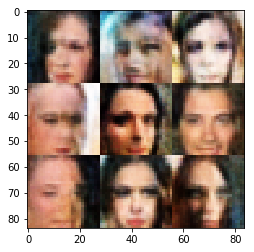

Epoch 3/5... Discriminator Loss: 1.4088... Generator Loss: 0.6800
Epoch 3/5... Discriminator Loss: 1.4036... Generator Loss: 0.7360
Epoch 3/5... Discriminator Loss: 1.4314... Generator Loss: 0.7054
Epoch 4/5... Discriminator Loss: 1.4147... Generator Loss: 0.6273


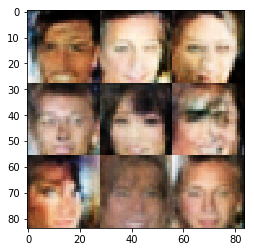

Epoch 4/5... Discriminator Loss: 1.4127... Generator Loss: 0.6114
Epoch 4/5... Discriminator Loss: 1.4177... Generator Loss: 0.6334
Epoch 4/5... Discriminator Loss: 1.4130... Generator Loss: 0.6905
Epoch 4/5... Discriminator Loss: 1.4235... Generator Loss: 0.6990


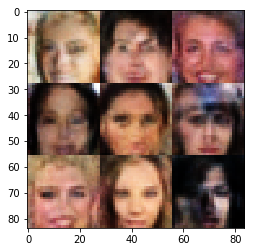

Epoch 4/5... Discriminator Loss: 1.4175... Generator Loss: 0.5896
Epoch 4/5... Discriminator Loss: 1.4055... Generator Loss: 0.6647
Epoch 4/5... Discriminator Loss: 1.3986... Generator Loss: 0.6485
Epoch 4/5... Discriminator Loss: 1.4198... Generator Loss: 0.6612


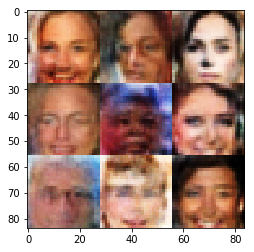

Epoch 4/5... Discriminator Loss: 1.4137... Generator Loss: 0.6702
Epoch 4/5... Discriminator Loss: 1.4099... Generator Loss: 0.6714
Epoch 4/5... Discriminator Loss: 1.4121... Generator Loss: 0.6831
Epoch 4/5... Discriminator Loss: 1.3977... Generator Loss: 0.6668


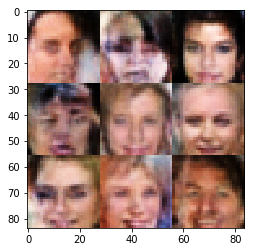

Epoch 4/5... Discriminator Loss: 1.4333... Generator Loss: 0.6304
Epoch 4/5... Discriminator Loss: 1.4011... Generator Loss: 0.6415
Epoch 4/5... Discriminator Loss: 1.4188... Generator Loss: 0.6658
Epoch 4/5... Discriminator Loss: 1.3963... Generator Loss: 0.6870


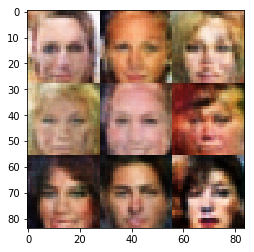

Epoch 4/5... Discriminator Loss: 1.4308... Generator Loss: 0.6715
Epoch 4/5... Discriminator Loss: 1.4049... Generator Loss: 0.6604
Epoch 4/5... Discriminator Loss: 1.4177... Generator Loss: 0.6445
Epoch 4/5... Discriminator Loss: 1.4064... Generator Loss: 0.6844


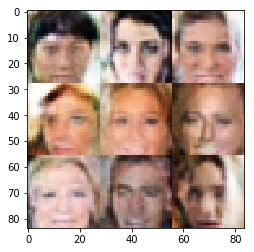

Epoch 4/5... Discriminator Loss: 1.4199... Generator Loss: 0.6315
Epoch 4/5... Discriminator Loss: 1.4377... Generator Loss: 0.7188
Epoch 4/5... Discriminator Loss: 1.4080... Generator Loss: 0.6358
Epoch 4/5... Discriminator Loss: 1.4083... Generator Loss: 0.6606


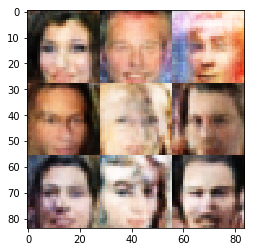

Epoch 4/5... Discriminator Loss: 1.4304... Generator Loss: 0.5888
Epoch 4/5... Discriminator Loss: 1.4169... Generator Loss: 0.7306
Epoch 4/5... Discriminator Loss: 1.4183... Generator Loss: 0.6218
Epoch 4/5... Discriminator Loss: 1.4119... Generator Loss: 0.6379


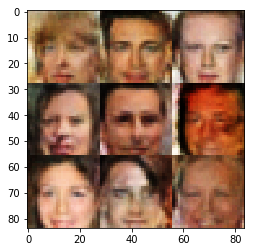

Epoch 4/5... Discriminator Loss: 1.4086... Generator Loss: 0.6115
Epoch 4/5... Discriminator Loss: 1.4192... Generator Loss: 0.6207
Epoch 4/5... Discriminator Loss: 1.4038... Generator Loss: 0.6875
Epoch 4/5... Discriminator Loss: 1.4224... Generator Loss: 0.6109


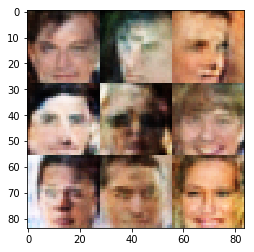

Epoch 4/5... Discriminator Loss: 1.4106... Generator Loss: 0.6013
Epoch 4/5... Discriminator Loss: 1.4212... Generator Loss: 0.6376
Epoch 4/5... Discriminator Loss: 1.4187... Generator Loss: 0.6980
Epoch 4/5... Discriminator Loss: 1.4168... Generator Loss: 0.6136


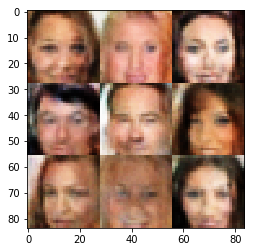

Epoch 4/5... Discriminator Loss: 1.4098... Generator Loss: 0.6359
Epoch 4/5... Discriminator Loss: 1.4267... Generator Loss: 0.6569
Epoch 4/5... Discriminator Loss: 1.4089... Generator Loss: 0.6893
Epoch 4/5... Discriminator Loss: 1.4071... Generator Loss: 0.6667


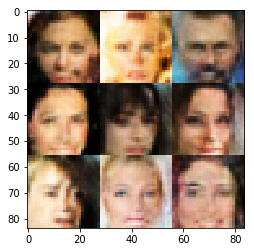

Epoch 4/5... Discriminator Loss: 1.4153... Generator Loss: 0.5987
Epoch 4/5... Discriminator Loss: 1.4169... Generator Loss: 0.6838
Epoch 4/5... Discriminator Loss: 1.4124... Generator Loss: 0.6890
Epoch 4/5... Discriminator Loss: 1.4251... Generator Loss: 0.6639


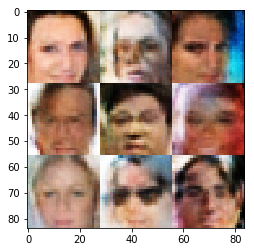

Epoch 4/5... Discriminator Loss: 1.4064... Generator Loss: 0.6831
Epoch 4/5... Discriminator Loss: 1.4204... Generator Loss: 0.6881
Epoch 4/5... Discriminator Loss: 1.4081... Generator Loss: 0.7365
Epoch 4/5... Discriminator Loss: 1.3985... Generator Loss: 0.6671


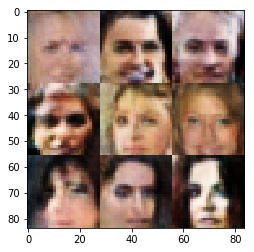

Epoch 4/5... Discriminator Loss: 1.4127... Generator Loss: 0.6170
Epoch 4/5... Discriminator Loss: 1.4185... Generator Loss: 0.6796
Epoch 4/5... Discriminator Loss: 1.3932... Generator Loss: 0.6318
Epoch 4/5... Discriminator Loss: 1.4186... Generator Loss: 0.6233


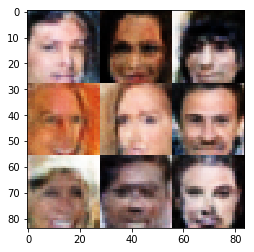

Epoch 4/5... Discriminator Loss: 1.4322... Generator Loss: 0.6650
Epoch 4/5... Discriminator Loss: 1.4147... Generator Loss: 0.7112
Epoch 4/5... Discriminator Loss: 1.4227... Generator Loss: 0.6017
Epoch 4/5... Discriminator Loss: 1.4227... Generator Loss: 0.7041


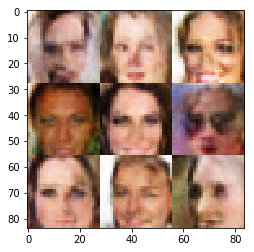

Epoch 4/5... Discriminator Loss: 1.4256... Generator Loss: 0.6604
Epoch 4/5... Discriminator Loss: 1.4061... Generator Loss: 0.6543
Epoch 4/5... Discriminator Loss: 1.4216... Generator Loss: 0.6048
Epoch 4/5... Discriminator Loss: 1.4086... Generator Loss: 0.6163


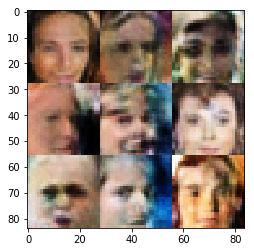

Epoch 4/5... Discriminator Loss: 1.4234... Generator Loss: 0.6045
Epoch 4/5... Discriminator Loss: 1.4040... Generator Loss: 0.6724
Epoch 4/5... Discriminator Loss: 1.4278... Generator Loss: 0.6065
Epoch 4/5... Discriminator Loss: 1.4204... Generator Loss: 0.6486


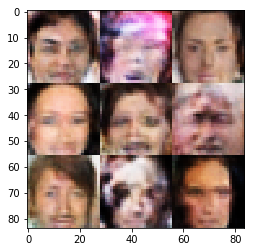

Epoch 4/5... Discriminator Loss: 1.4048... Generator Loss: 0.6789
Epoch 4/5... Discriminator Loss: 1.4103... Generator Loss: 0.6264
Epoch 4/5... Discriminator Loss: 1.4254... Generator Loss: 0.6590
Epoch 4/5... Discriminator Loss: 1.4098... Generator Loss: 0.7037


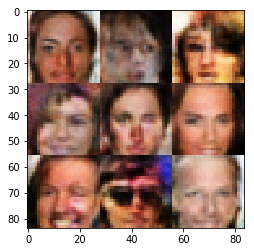

Epoch 4/5... Discriminator Loss: 1.4233... Generator Loss: 0.6076
Epoch 4/5... Discriminator Loss: 1.4125... Generator Loss: 0.6464
Epoch 4/5... Discriminator Loss: 1.4096... Generator Loss: 0.6701
Epoch 4/5... Discriminator Loss: 1.4317... Generator Loss: 0.6471


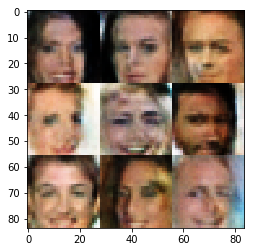

Epoch 4/5... Discriminator Loss: 1.4387... Generator Loss: 0.6287
Epoch 4/5... Discriminator Loss: 1.4209... Generator Loss: 0.6964
Epoch 4/5... Discriminator Loss: 1.4088... Generator Loss: 0.7488
Epoch 4/5... Discriminator Loss: 1.4053... Generator Loss: 0.6178


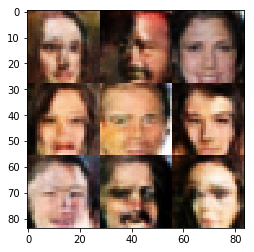

Epoch 4/5... Discriminator Loss: 1.4135... Generator Loss: 0.7072
Epoch 4/5... Discriminator Loss: 1.4243... Generator Loss: 0.5726
Epoch 4/5... Discriminator Loss: 1.4325... Generator Loss: 0.6437
Epoch 4/5... Discriminator Loss: 1.4128... Generator Loss: 0.6471


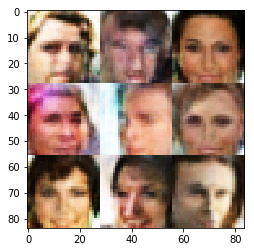

Epoch 4/5... Discriminator Loss: 1.4142... Generator Loss: 0.6325
Epoch 4/5... Discriminator Loss: 1.4220... Generator Loss: 0.6043
Epoch 4/5... Discriminator Loss: 1.4131... Generator Loss: 0.6497
Epoch 4/5... Discriminator Loss: 1.4015... Generator Loss: 0.6693


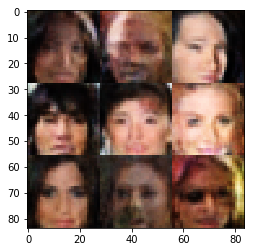

Epoch 4/5... Discriminator Loss: 1.4062... Generator Loss: 0.6592
Epoch 4/5... Discriminator Loss: 1.4307... Generator Loss: 0.5889
Epoch 4/5... Discriminator Loss: 1.4164... Generator Loss: 0.6385
Epoch 4/5... Discriminator Loss: 1.4093... Generator Loss: 0.6460


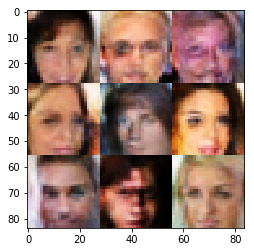

Epoch 4/5... Discriminator Loss: 1.4110... Generator Loss: 0.6646
Epoch 4/5... Discriminator Loss: 1.4209... Generator Loss: 0.6802
Epoch 4/5... Discriminator Loss: 1.4179... Generator Loss: 0.6306
Epoch 4/5... Discriminator Loss: 1.4362... Generator Loss: 0.5561


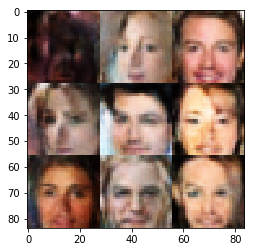

Epoch 4/5... Discriminator Loss: 1.4205... Generator Loss: 0.7112
Epoch 4/5... Discriminator Loss: 1.4215... Generator Loss: 0.6404
Epoch 4/5... Discriminator Loss: 1.4193... Generator Loss: 0.6777
Epoch 4/5... Discriminator Loss: 1.4129... Generator Loss: 0.7055


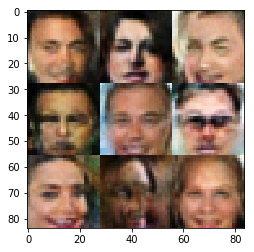

Epoch 4/5... Discriminator Loss: 1.4275... Generator Loss: 0.6063
Epoch 4/5... Discriminator Loss: 1.4250... Generator Loss: 0.6171
Epoch 4/5... Discriminator Loss: 1.4285... Generator Loss: 0.6557
Epoch 4/5... Discriminator Loss: 1.4143... Generator Loss: 0.6382


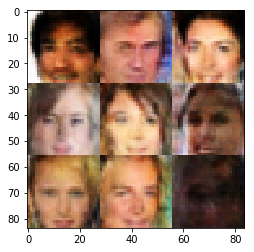

Epoch 4/5... Discriminator Loss: 1.4121... Generator Loss: 0.6651
Epoch 4/5... Discriminator Loss: 1.4142... Generator Loss: 0.6181
Epoch 4/5... Discriminator Loss: 1.4059... Generator Loss: 0.6381
Epoch 4/5... Discriminator Loss: 1.4227... Generator Loss: 0.6327


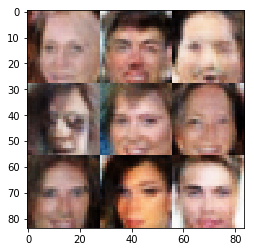

Epoch 4/5... Discriminator Loss: 1.4146... Generator Loss: 0.6215
Epoch 4/5... Discriminator Loss: 1.4196... Generator Loss: 0.6116
Epoch 4/5... Discriminator Loss: 1.4195... Generator Loss: 0.6838
Epoch 4/5... Discriminator Loss: 1.4158... Generator Loss: 0.6534


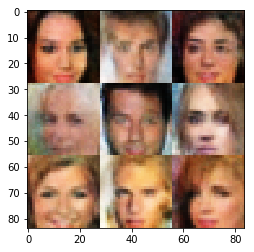

Epoch 4/5... Discriminator Loss: 1.4078... Generator Loss: 0.6498
Epoch 4/5... Discriminator Loss: 1.4069... Generator Loss: 0.6320
Epoch 4/5... Discriminator Loss: 1.4240... Generator Loss: 0.6766
Epoch 4/5... Discriminator Loss: 1.4153... Generator Loss: 0.6877


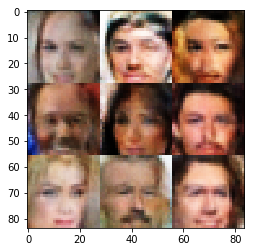

Epoch 4/5... Discriminator Loss: 1.4045... Generator Loss: 0.6213
Epoch 4/5... Discriminator Loss: 1.4043... Generator Loss: 0.6500
Epoch 4/5... Discriminator Loss: 1.4143... Generator Loss: 0.6678
Epoch 4/5... Discriminator Loss: 1.4223... Generator Loss: 0.6246


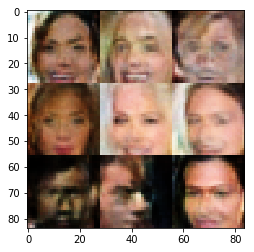

Epoch 4/5... Discriminator Loss: 1.4034... Generator Loss: 0.6672
Epoch 4/5... Discriminator Loss: 1.4277... Generator Loss: 0.6565
Epoch 4/5... Discriminator Loss: 1.4115... Generator Loss: 0.6382
Epoch 4/5... Discriminator Loss: 1.4214... Generator Loss: 0.6432


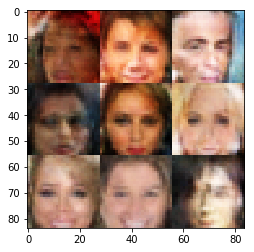

Epoch 4/5... Discriminator Loss: 1.4309... Generator Loss: 0.6132
Epoch 4/5... Discriminator Loss: 1.4151... Generator Loss: 0.6161
Epoch 4/5... Discriminator Loss: 1.4143... Generator Loss: 0.6992
Epoch 4/5... Discriminator Loss: 1.4104... Generator Loss: 0.6857


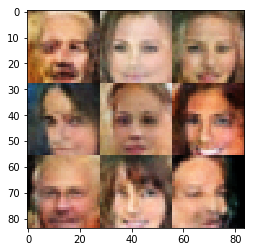

Epoch 4/5... Discriminator Loss: 1.4296... Generator Loss: 0.6083
Epoch 4/5... Discriminator Loss: 1.4217... Generator Loss: 0.6100
Epoch 5/5... Discriminator Loss: 1.4196... Generator Loss: 0.7072
Epoch 5/5... Discriminator Loss: 1.4303... Generator Loss: 0.5910


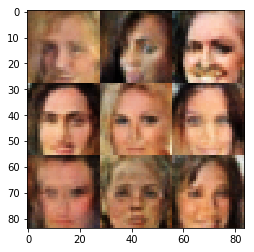

Epoch 5/5... Discriminator Loss: 1.4307... Generator Loss: 0.5779
Epoch 5/5... Discriminator Loss: 1.4054... Generator Loss: 0.7177
Epoch 5/5... Discriminator Loss: 1.4110... Generator Loss: 0.6686
Epoch 5/5... Discriminator Loss: 1.4196... Generator Loss: 0.6437


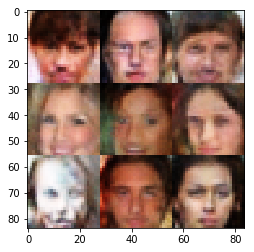

Epoch 5/5... Discriminator Loss: 1.4352... Generator Loss: 0.5856
Epoch 5/5... Discriminator Loss: 1.4201... Generator Loss: 0.6838
Epoch 5/5... Discriminator Loss: 1.4121... Generator Loss: 0.6373
Epoch 5/5... Discriminator Loss: 1.4279... Generator Loss: 0.6344


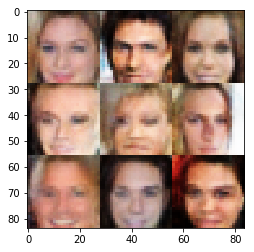

Epoch 5/5... Discriminator Loss: 1.4078... Generator Loss: 0.6680
Epoch 5/5... Discriminator Loss: 1.4060... Generator Loss: 0.6150
Epoch 5/5... Discriminator Loss: 1.4036... Generator Loss: 0.6704
Epoch 5/5... Discriminator Loss: 1.4191... Generator Loss: 0.7319


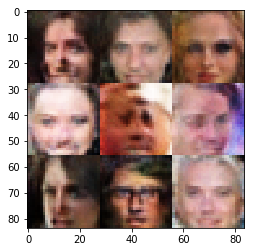

Epoch 5/5... Discriminator Loss: 1.4333... Generator Loss: 0.6687
Epoch 5/5... Discriminator Loss: 1.4101... Generator Loss: 0.6884
Epoch 5/5... Discriminator Loss: 1.4256... Generator Loss: 0.6479
Epoch 5/5... Discriminator Loss: 1.4167... Generator Loss: 0.5977


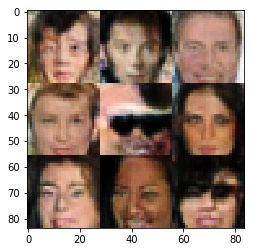

Epoch 5/5... Discriminator Loss: 1.4171... Generator Loss: 0.6235
Epoch 5/5... Discriminator Loss: 1.4136... Generator Loss: 0.6814
Epoch 5/5... Discriminator Loss: 1.4040... Generator Loss: 0.6520
Epoch 5/5... Discriminator Loss: 1.4129... Generator Loss: 0.6641


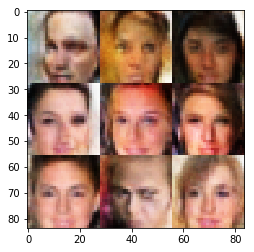

Epoch 5/5... Discriminator Loss: 1.4058... Generator Loss: 0.6874
Epoch 5/5... Discriminator Loss: 1.4271... Generator Loss: 0.6349
Epoch 5/5... Discriminator Loss: 1.4019... Generator Loss: 0.7084
Epoch 5/5... Discriminator Loss: 1.4076... Generator Loss: 0.6183


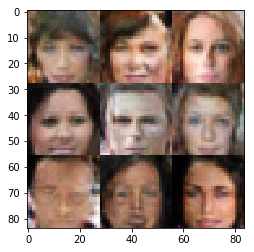

Epoch 5/5... Discriminator Loss: 1.4085... Generator Loss: 0.6744
Epoch 5/5... Discriminator Loss: 1.4167... Generator Loss: 0.6179
Epoch 5/5... Discriminator Loss: 1.4069... Generator Loss: 0.6950
Epoch 5/5... Discriminator Loss: 1.4071... Generator Loss: 0.6426


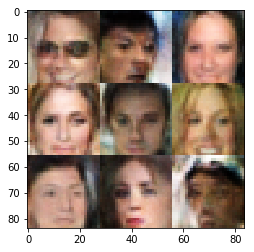

Epoch 5/5... Discriminator Loss: 1.4141... Generator Loss: 0.6340
Epoch 5/5... Discriminator Loss: 1.3963... Generator Loss: 0.6443
Epoch 5/5... Discriminator Loss: 1.4208... Generator Loss: 0.6682
Epoch 5/5... Discriminator Loss: 1.4387... Generator Loss: 0.5913


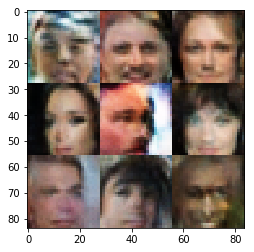

Epoch 5/5... Discriminator Loss: 1.4032... Generator Loss: 0.6431
Epoch 5/5... Discriminator Loss: 1.4212... Generator Loss: 0.6481
Epoch 5/5... Discriminator Loss: 1.4054... Generator Loss: 0.6725
Epoch 5/5... Discriminator Loss: 1.4157... Generator Loss: 0.6391


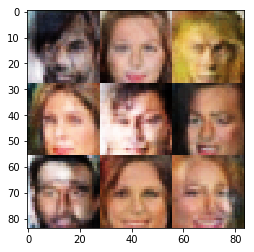

Epoch 5/5... Discriminator Loss: 1.4003... Generator Loss: 0.6728
Epoch 5/5... Discriminator Loss: 1.4213... Generator Loss: 0.6461
Epoch 5/5... Discriminator Loss: 1.3964... Generator Loss: 0.6333
Epoch 5/5... Discriminator Loss: 1.4175... Generator Loss: 0.6638


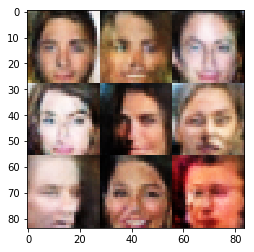

Epoch 5/5... Discriminator Loss: 1.4049... Generator Loss: 0.6450
Epoch 5/5... Discriminator Loss: 1.4085... Generator Loss: 0.6235
Epoch 5/5... Discriminator Loss: 1.4074... Generator Loss: 0.6961
Epoch 5/5... Discriminator Loss: 1.4158... Generator Loss: 0.7011


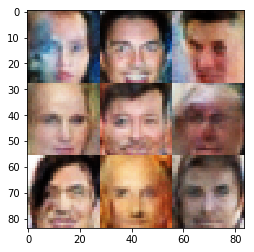

Epoch 5/5... Discriminator Loss: 1.4147... Generator Loss: 0.6980
Epoch 5/5... Discriminator Loss: 1.4147... Generator Loss: 0.6696
Epoch 5/5... Discriminator Loss: 1.4240... Generator Loss: 0.6686
Epoch 5/5... Discriminator Loss: 1.4251... Generator Loss: 0.6394


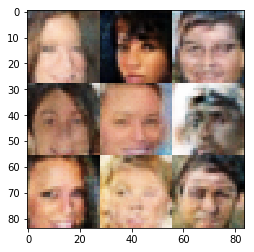

Epoch 5/5... Discriminator Loss: 1.4186... Generator Loss: 0.6436
Epoch 5/5... Discriminator Loss: 1.4188... Generator Loss: 0.6339
Epoch 5/5... Discriminator Loss: 1.4167... Generator Loss: 0.5980
Epoch 5/5... Discriminator Loss: 1.4118... Generator Loss: 0.6250


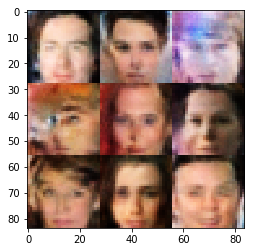

Epoch 5/5... Discriminator Loss: 1.4224... Generator Loss: 0.7092
Epoch 5/5... Discriminator Loss: 1.4296... Generator Loss: 0.6618
Epoch 5/5... Discriminator Loss: 1.4206... Generator Loss: 0.6643
Epoch 5/5... Discriminator Loss: 1.4008... Generator Loss: 0.6867


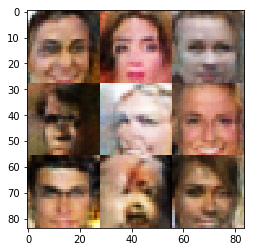

Epoch 5/5... Discriminator Loss: 1.4006... Generator Loss: 0.6675
Epoch 5/5... Discriminator Loss: 1.4088... Generator Loss: 0.6693
Epoch 5/5... Discriminator Loss: 1.4084... Generator Loss: 0.6411
Epoch 5/5... Discriminator Loss: 1.4201... Generator Loss: 0.6680


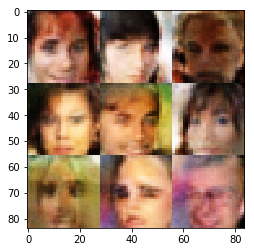

Epoch 5/5... Discriminator Loss: 1.4131... Generator Loss: 0.6459
Epoch 5/5... Discriminator Loss: 1.4237... Generator Loss: 0.6347
Epoch 5/5... Discriminator Loss: 1.4167... Generator Loss: 0.6221
Epoch 5/5... Discriminator Loss: 1.4151... Generator Loss: 0.6713


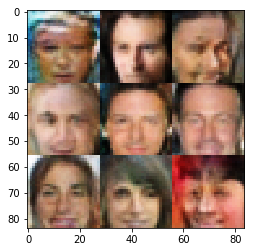

Epoch 5/5... Discriminator Loss: 1.4229... Generator Loss: 0.6924
Epoch 5/5... Discriminator Loss: 1.4162... Generator Loss: 0.6956
Epoch 5/5... Discriminator Loss: 1.4212... Generator Loss: 0.7028
Epoch 5/5... Discriminator Loss: 1.4105... Generator Loss: 0.6878


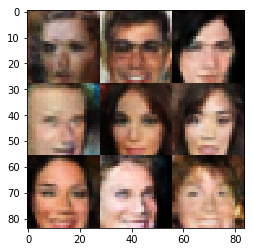

Epoch 5/5... Discriminator Loss: 1.4043... Generator Loss: 0.6687
Epoch 5/5... Discriminator Loss: 1.4067... Generator Loss: 0.6541
Epoch 5/5... Discriminator Loss: 1.4141... Generator Loss: 0.6603
Epoch 5/5... Discriminator Loss: 1.4178... Generator Loss: 0.6433


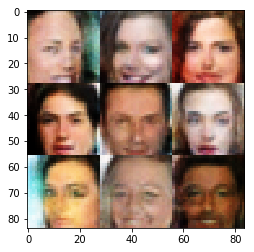

Epoch 5/5... Discriminator Loss: 1.4116... Generator Loss: 0.7064
Epoch 5/5... Discriminator Loss: 1.4105... Generator Loss: 0.6533
Epoch 5/5... Discriminator Loss: 1.4059... Generator Loss: 0.7067
Epoch 5/5... Discriminator Loss: 1.4084... Generator Loss: 0.6164


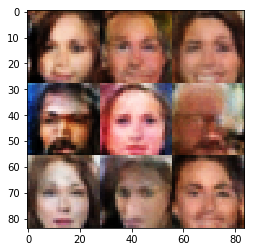

Epoch 5/5... Discriminator Loss: 1.4093... Generator Loss: 0.5875
Epoch 5/5... Discriminator Loss: 1.4063... Generator Loss: 0.6485
Epoch 5/5... Discriminator Loss: 1.4251... Generator Loss: 0.5940
Epoch 5/5... Discriminator Loss: 1.4280... Generator Loss: 0.6475


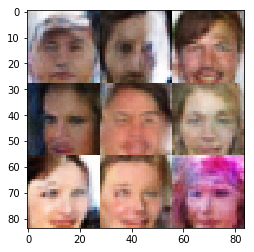

Epoch 5/5... Discriminator Loss: 1.4177... Generator Loss: 0.6654
Epoch 5/5... Discriminator Loss: 1.4138... Generator Loss: 0.6762
Epoch 5/5... Discriminator Loss: 1.4219... Generator Loss: 0.6273
Epoch 5/5... Discriminator Loss: 1.4057... Generator Loss: 0.6406


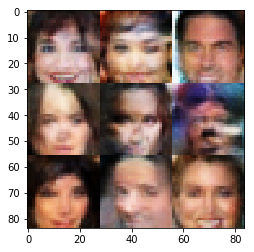

Epoch 5/5... Discriminator Loss: 1.4065... Generator Loss: 0.6960
Epoch 5/5... Discriminator Loss: 1.4321... Generator Loss: 0.6556
Epoch 5/5... Discriminator Loss: 1.4198... Generator Loss: 0.6542
Epoch 5/5... Discriminator Loss: 1.4182... Generator Loss: 0.7142


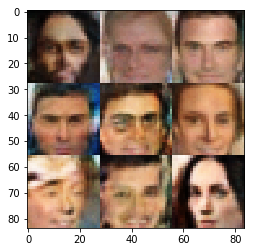

Epoch 5/5... Discriminator Loss: 1.4174... Generator Loss: 0.6410
Epoch 5/5... Discriminator Loss: 1.4219... Generator Loss: 0.6949
Epoch 5/5... Discriminator Loss: 1.4238... Generator Loss: 0.6352
Epoch 5/5... Discriminator Loss: 1.4118... Generator Loss: 0.6376


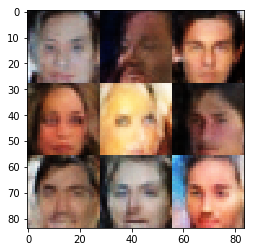

Epoch 5/5... Discriminator Loss: 1.4262... Generator Loss: 0.6036
Epoch 5/5... Discriminator Loss: 1.4098... Generator Loss: 0.6878
Epoch 5/5... Discriminator Loss: 1.4047... Generator Loss: 0.6608
Epoch 5/5... Discriminator Loss: 1.4143... Generator Loss: 0.6437


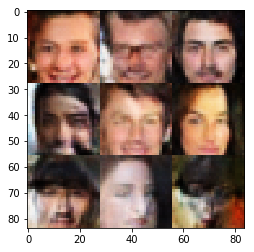

Epoch 5/5... Discriminator Loss: 1.4246... Generator Loss: 0.6361
Epoch 5/5... Discriminator Loss: 1.4122... Generator Loss: 0.6172
Epoch 5/5... Discriminator Loss: 1.3953... Generator Loss: 0.6750
Epoch 5/5... Discriminator Loss: 1.4082... Generator Loss: 0.6494


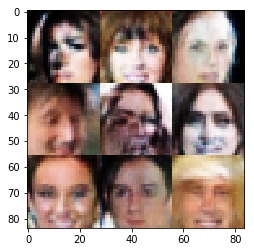

Epoch 5/5... Discriminator Loss: 1.4084... Generator Loss: 0.6665
Epoch 5/5... Discriminator Loss: 1.4209... Generator Loss: 0.6626
Epoch 5/5... Discriminator Loss: 1.4236... Generator Loss: 0.6888
Epoch 5/5... Discriminator Loss: 1.4045... Generator Loss: 0.6625


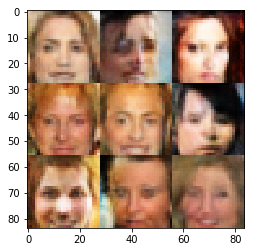

Epoch 5/5... Discriminator Loss: 1.4121... Generator Loss: 0.6841
Epoch 5/5... Discriminator Loss: 1.4098... Generator Loss: 0.6495
Epoch 5/5... Discriminator Loss: 1.4239... Generator Loss: 0.6003
Epoch 5/5... Discriminator Loss: 1.4129... Generator Loss: 0.6323


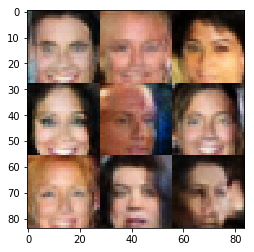

Epoch 5/5... Discriminator Loss: 1.4097... Generator Loss: 0.6779
Epoch 5/5... Discriminator Loss: 1.4095... Generator Loss: 0.7099
Epoch 5/5... Discriminator Loss: 1.4359... Generator Loss: 0.6288
Epoch 5/5... Discriminator Loss: 1.4100... Generator Loss: 0.6574


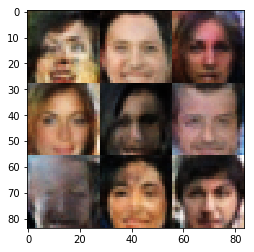

Epoch 5/5... Discriminator Loss: 1.4130... Generator Loss: 0.7043
Epoch 5/5... Discriminator Loss: 1.3984... Generator Loss: 0.7098
Epoch 5/5... Discriminator Loss: 1.4113... Generator Loss: 0.6556
Epoch 5/5... Discriminator Loss: 1.3974... Generator Loss: 0.7021


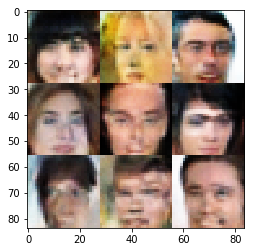

Epoch 5/5... Discriminator Loss: 1.4129... Generator Loss: 0.6676
Epoch 5/5... Discriminator Loss: 1.4152... Generator Loss: 0.6205
Epoch 5/5... Discriminator Loss: 1.4206... Generator Loss: 0.6567
Epoch 5/5... Discriminator Loss: 1.4143... Generator Loss: 0.6662


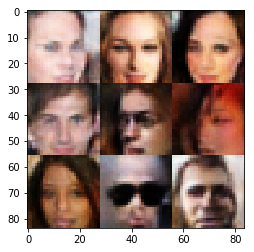

Epoch 5/5... Discriminator Loss: 1.4053... Generator Loss: 0.6606
Epoch 5/5... Discriminator Loss: 1.4194... Generator Loss: 0.6503
Epoch 5/5... Discriminator Loss: 1.4278... Generator Loss: 0.6109
Epoch 5/5... Discriminator Loss: 1.4047... Generator Loss: 0.6681


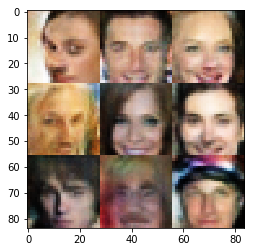

Epoch 5/5... Discriminator Loss: 1.4171... Generator Loss: 0.7089


In [28]:
batch_size    = 64
z_dim         = 200
learning_rate = 0.0001
beta1         = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 5

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.